# Probabilidade e Estatística: Atividade G2-B
Aluno: Renan de Oliveira Pereira
Matrícula: 2512109

### Importando bibliotecas

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict,Sequence, Optional, Tuple, List
import scipy.stats as stats
import matplotlib
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import f


## Funcões auxiliares

### Métricas de modelo

In [3]:
def calcula_r2(X:np.ndarray, y:np.ndarray,betas:np.ndarray, ) -> float:
    """
    Calcula o R^2 de um modelo de regressao linear, dada uma matriz X de preditores,
    um vetor y de observacões do target e os betas estimados da regressão linear
    """

    # Capturando o numero de observacões da matriz
    n = len(y)

    # Vamos separar o numerador e o denominador do R^2 para que o código fique mais legível
    numerator = (betas.T @ X.T @ y) - n * (np.mean(y)**2)
    denominator = y.T @ y - n * (np.mean(y)**2)

    # Garantir que o denominador nao é nulo para uma tolerancia de 1e-16
    assert abs(denominator) > 1e-16

    return numerator/denominator

In [4]:
def calcula_r2_adj(r2:float, p:int, n:int) -> float:
    """
    Calula o R^2 ajustado em funcão do R^2, do número p de preditores e do número n de observacões.
    """
    return (
        1 -
        ( (1 - r2) / (n-p-1) )
        * (n-1)
        )

In [5]:
def print_resultados(reg_results : Dict):
    """Printa resultados consolidados do modelo de um modelo {reg_results} estimado."""
    print(f"Intercepto: {reg_results["intercept"]}" )
    print(f"Coeficientes beta (comecando em B_1): {reg_results["betas"]}" )
    print(f"R²: {reg_results["r2"]:.8f}") # Ajusta para 8 casas decimais (tive que usar mais casas para que nao fique 0 em alguns casos)
    print(f"R² Ajustado: {reg_results["adj-r2"]:.4f}")  # Ajusta para 4 casas decimais


### Diagnóstico de resíduos

In [6]:
def print_quantis(e:np.ndarray) -> Dict:
    """Retorna um dicionário com os principais quantis de uma distribuicão de dados"""
    return {
        "min":min(e),
        "q1": np.quantile(e, 0.25),
        "median": np.quantile(e, 0.5),
        "q3": np.quantile(e, 0.75),
        "max": max(e)
    }

In [7]:
def plot_residuals(e:np.ndarray, figsize=(12,5)):
    """Plota os resíduos de um modelo de regressão"""

    # Cria figura e eixos
    fig, ax = plt.subplots(figsize=figsize)

    # Plota scatterplot baseada no índice criado dinamicamente e no valor do resíduo
    sns.lineplot(
        x=np.arange(1, len(e) + 1), # Numero de observacoes
        y = e,
        ax=ax,
        marker="o",
        lw=0.5,
        label="Resíduos"
        )

    # Plotando média dos erros
    avg_e = np.mean(e)
    plt.axhline(y=avg_e, linestyle="--", label=f"Média dos erros: {avg_e:.3f}")

    # Cria rótulos necessários
    ax.set_title("Gráfico de resíduos")
    ax.set_xlabel("Observacão")
    ax.set_ylabel("Resíduos")
    ax.legend()



    plt.show()

In [8]:
def plot_qq_plot(e:np.ndarray, figsize=(12,5)):
    """
    Plota o qq plot dos resíduos referente a uma distribuicão. Depende da funcão probplot do scipy stats.
    """
    fig, ax = plt.subplots(figsize=figsize)
    stats.probplot(e, dist="norm", plot=ax)

    # Traduzindo rótulos
    ax.set_title("Gráfico de Probabilidades (QQ-Plot)")
    ax.set_xlabel("Quantis teóricos")
    ax.set_ylabel("Valores ordenados")

    plt.show()


In [9]:
def plot_histogram(e:np.ndarray, figsize=(12,5)):
    """
    Plota o histograma dos erros.
    """
    # Cria figura e eixos
    fig, ax = plt.subplots(figsize=figsize)

    # Cria o histograma
    sns.histplot(x=e, ax=ax)

    # Cria rótulos
    ax.set_title("Histograma dos resíduos")
    ax.set_xlabel("Resíduos")

In [10]:
def diagnostico_de_residuos(e: np.ndarray, X:np.ndarray) -> Dict:
    """
    Calcula sequenciamente todos os passos do diagnostico de erros:
    1 - Printa os quantis da distribuicão dos erros
    2 - Plotta o histograma dos erros
    3 - Plotta o qq plot para verificar o ajuste dos erros ao modelo normal (útil para verificar premissa normalidade dos erros)
    4 - Plotta o gráfico de linha com os resíduos (útil para veriificar premissas de homocedasticidade, não autocorrelacào e média = 0)
    5 - Realiza o teste de shapiro wilk para normalidade
    6 - Realiza o teste de breusch-pagan para heterocedasticidade
    7 - Calcula o valor da estatística de durbin watson (autocorrelacão)

    Retorna um dicionário com as estatísticas de teste os p-valores dos testes.
    """

    # 1: quantis
    print_quantis(e)

    # 2: histograma dos erros
    plot_histogram(e)

    # 3: QQ Plot
    plot_qq_plot(e)

    # 4: Gráfico de linha dos resíduos
    plot_residuals(e)

    # 5: Teste de shapiro (Normalidade)
    shapiro_statistic, shapiro_p_value = stats.shapiro(e)
    print("### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###")
    print("H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS\nH1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS")
    print(f"Estatística de shapiro: {shapiro_statistic}, p-valor do teste de Shapiro: {shapiro_p_value}")

    # 6: Teste de Breusch Pagan (Heterocedasticidade)
    breusch_pagan_statistic, breusch_pagan_p_value, _, _  = het_breuschpagan(e, X)
    print("### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###")
    print("H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) \nH1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)")
    print(f"Estatística do Lagrange Multiplier: {breusch_pagan_statistic}, p-valor do teste de Breusch Pagan: {breusch_pagan_p_value}")

    # 7: Estatística de Breusch pagan
    durbin_watson_statistic = durbin_watson(e)
    print("### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###")
    print(f"VALOR DA ESTATÍSTICA DE DURBIN WATSON: {durbin_watson_statistic}")
    print("(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores para o teste)")

    return {
        "shapiro_statistic":  shapiro_statistic,
        "shapiro_p_value": shapiro_p_value,
        "breusch_pagan_statistic": breusch_pagan_statistic,
        "breusch_pagan_p_value":breusch_pagan_p_value,
        "durbin_watson_statistic": durbin_watson_statistic
    }


## Exercício 1)

### Importando dados e fazendo verificacões básicas

In [11]:
DATASET_PATH = "MA_Dados_Gripe_Idosos_Municipio.csv"
df = pd.read_csv(DATASET_PATH)
df.head()

,municipio_codigo,municipio_nome,uf,regiao,tipo_urbano,gini,idhm_100,distancia_capital,dens_demografica,pop_idosa,cobertura_aps,profissionais_100_mil,renda_capta,coleta_lixo_perc,esgoto_sanitario_perc,cob_vac_gripe_idosos
0,2110708,São Domingos do Maranhão,MA,Nordeste,Semi_Urbano,0.5944,58.2,335.638591,29.847792,3710,100.00,124.476501,230.01,16.6,16.2,94.23
1,2108058,Paulino Neves,MA,Nordeste,Rural,0.6201,56.1,195.969362,16.500313,1188,100.00,129.283682,158.01,0.1,12.4,98.66
2,2102507,Cajari,MA,Nordeste,Rural,0.6273,52.3,117.901552,29.379246,1644,89.35,80.201532,131.18,3.7,6.0,81.62
3,2109205,Presidente Juscelino,MA,Nordeste,Rural,0.6115,56.3,50.253199,36.105611,915,100.00,90.356753,132.33,3.4,1.1,90.45
4,2105203,Igarapé Grande,MA,Nordeste,Rural,0.5319,61.4,243.771744,32.889682,1359,100.00,122.947221,287.25,40.0,20.3,101.19


Vamos checar minimamente a qualidade do conjunto de dados, para garantir que não há a presenca de dados nulos ou de formatos de coluna inconsistentes.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   municipio_codigo       50 non-null     int64  
 1   municipio_nome         50 non-null     object 
 2   uf                     50 non-null     object 
 3   regiao                 50 non-null     object 
 4   tipo_urbano            50 non-null     object 
 5   gini                   50 non-null     float64
 6   idhm_100               50 non-null     float64
 7   distancia_capital      50 non-null     float64
 8   dens_demografica       50 non-null     float64
 9   pop_idosa              50 non-null     int64  
 10  cobertura_aps          50 non-null     float64
 11  profissionais_100_mil  50 non-null     float64
 12  renda_capta            50 non-null     float64
 13  coleta_lixo_perc       50 non-null     float64
 14  esgoto_sanitario_perc  50 non-null     float64
 15  cob_vac_

In [13]:
df.isna().sum()

municipio_codigo         0
municipio_nome           0
uf                       0
regiao                   0
tipo_urbano              0
gini                     0
idhm_100                 0
distancia_capital        0
dens_demografica         0
pop_idosa                0
cobertura_aps            0
profissionais_100_mil    0
renda_capta              0
coleta_lixo_perc         0
esgoto_sanitario_perc    0
cob_vac_gripe_idosos     0
dtype: int64

Os formatos de dados estão OK, e não há a presenca de dados faltantes, portanto podemos prosseguir.

### a) Gráfico de dispersão IDH x Cobertura Vacinal 

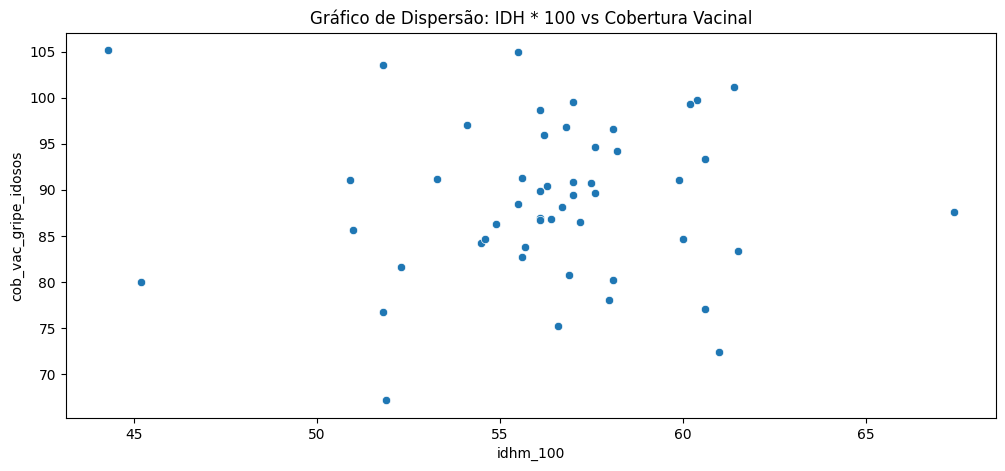

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(df, x="idhm_100", y="cob_vac_gripe_idosos")
ax.set_title("Gráfico de Dispersão: IDH * 100 vs Cobertura Vacinal")
plt.show()

Vemos que não parece existir uma relacão clara entre o idh x 100 e a cobertura vacinal. Ou seja, não há indícios de que lugares mais desenvolvidos, i.e., com maior IDH, apresentem uma maior cobertura vacinal.

### b) Modelo de regressão linear simples, considerando apenas grau 1 das variáveis.
A funcão a seguir foi desenvolvida para estimar o modelo de regressão linear de forma genérica, ou seja, tanto para a regressão linear simples, quanto para a múltipla. A formulacão foi feita com base na notacão matricial para modelos de regressão descrita no apêndice C do livro "Econometria Básica", quinta edicão, em português, do autor Damodar Gujarati.

In [15]:
def regressao_linear(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calcula os coeficientes de um modelo de regressão linear com base em uma matriz X de preditores
    e um vetor y com os valores do target
    """
    # Capturando o numero de linhas da matriz X
    nrows = X.shape[0]

    # Criando vetor apenas com numeros 1 para representar o intercepto na matriz de preditores
    ones = np.ones(nrows)

    # Incluindo coluna de 1's no inicio da matriz para representar o intercepto da regressao
    X = np.column_stack(
        (ones, X)
    )

    # Definindo modelo matricial para cálculo dos coeficientes:
    # B = (X_T * X)^-1 X.T * y
    # OBS: Para que a funcão generalize para casos em que X não admite inversa, usa-se a pseudoinversa de X.T * X, cuja implementacão no pacote numpy
    # é feita a partir do Single Value Decomposition (SVD). Para os casos em que existe a inversa da matriz X, a pseudoinversa deve coincidir com a
    # a matriz inversa de X (sujeito a aproximacão computacional). Para usa
    betas = np.linalg.inv(X.T @ X) @ X.T @ y

    # Calculando estimativas / previsões para cada amostra x
    preds = X @ betas

    # Calculando desvios do modelo em cada observacao
    residuals = y - preds

    # Calcula o R^2 do modelo
    r2 = calcula_r2(X=X, y=y, betas=betas)

    # Calcula o r2 ajustado
    adj_r2 = calcula_r2_adj(r2=r2, p=X.shape[1]-1, n=X.shape[0]) # É necessário subtrair 1 do número de colunas de X para descontar a coluna de 1s

    # Outputs:
    results = {
        "intercept": betas[0],
        "betas": betas[1:],
        "predictions": preds,
        "X": X,
        "residuals": residuals,
        "r2": r2,
        "adj-r2": adj_r2
    }
    return results


In [16]:
# Converte vetor do preditor idhm_100 e da cobertura vacinal para um np.ndarray
X = df["idhm_100"].to_numpy()
y = df["cob_vac_gripe_idosos"].to_numpy()

In [17]:
reg_simples = regressao_linear(X, y)
print_resultados(reg_results=reg_simples)

Intercepto: 88.92242662804132
Coeficientes beta (comecando em B_1): [-0.00173043]
R²: 0.00000064
R² Ajustado: -0.0208


Vamos fazer um sanity check e comparar com os resultados da biblioteca Scikit-learn

In [18]:
reg = LinearRegression(fit_intercept=True).fit(X.reshape(-1,1), y)
print(f"Intercepto: {reg.intercept_}\nBeta1: {reg.coef_[0]}")

Intercepto: 88.92242662804271
Beta1: -0.0017304292572681962


Vemos que o resultado está conforme com o modelo de regressão linear do Scikit Learn.

### c) Modelo com termos quadráticos
Para incluir o termo quadrático no modelo, basta incluir uma coluna para um novo preditor em nossa matriz. Essa nova coluna será igual ao quadrado do nosso preditor original.

In [19]:
# Inclui uma coluna a direita em nossa matriz, com o quadrado da coluna original.
X2 = np.column_stack((X, X**2))

#  Calcula a regressão com termo quadrático
reg_quadratica = regressao_linear(X2, y)
print_resultados(reg_results=reg_quadratica)

Intercepto: 132.41966492474918
Coeficientes beta (comecando em B_1): [-1.58602314  0.0143503 ]
R²: 0.00256261
R² Ajustado: -0.0399


Novamente podemos fazer um sanity check com a funcão do modelo de regressão linear do pacote Scikit Learn. 

In [20]:
reg = LinearRegression(fit_intercept=True).fit(X2, y)
print(f"Intercepto: {reg.intercept_}\nBeta1: {reg.coef_[0]}, Beta2: {reg.coef_[1]}")

Intercepto: 132.41966492498034
Beta1: -1.5860231387360464, Beta2: 0.014350298168638812


E vemos que os valores estão corretos.

### d) Modelo com termos cúbicos

Assim como feito na letra c) do exercício, apenas concatenammos as colunas do termo quadrático e do termo cúbico a matriz original com apenas 1 preditor.

In [21]:
# Inclui as colunas dos termos quadráticos e cúbicos na matriz de preditores.
X3 = np.column_stack(
    (X, X**2, X**3)
)

reg_cubica = regressao_linear(X3, y)
print_resultados(reg_results=reg_cubica)

Intercepto: 1281.6319644029436
Coeficientes beta (comecando em B_1): [-6.46975776e+01  1.15970296e+00 -6.87260497e-03]
R²: 0.03090254
R² Ajustado: -0.0323


E outra vez podemos fazer o sanity check usando o scikit learn

In [22]:
reg = LinearRegression(fit_intercept=True).fit(X3, y)
print(f"Intercepto: {reg.intercept_}\nBeta1: {reg.coef_[0]}, Beta2: {reg.coef_[1]}, Beta3: {reg.coef_[2]}")

Intercepto: 1281.6319599617077
Beta1: -64.69757730296116, Beta2: 1.1597029568632764, Beta3: -0.006872604947973704


E uma vez mais vemos que o modelo está ajustado corretamente.

### e) Modelo de spline linear (piecewise)
Para esse modelo, podemos considerar que existe um primeiro termo B1, que vale para o primeiro pedaco da funcão, e depois, a partir do nó que conecta as linhas, temos o coeficiente (B1 + B2), de forma que B2 é o incremento (ou decremento) aplicado em B1 apos o nó.

In [23]:
def regressao_linear_piecewise_mediana(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calcula os coeficientes de um modelo de regressão linear piecewise com base em uma matriz X de preditores
    e um vetor y com os valores do target. O nó que conecta as linhas do modelo piecewise é definido como a mediana
    da variável X.
    """

    # Funcão está adaptada apenas para o caso em que temos só 1 preditor, portanto é necessário garantir que X é vetor, e não uma matriz. Ou seja, seu parametro shape tem apenas 1 coordenada.
    assert len(X.shape) == 1

    # Capturando o numero de linhas da matriz X
    nrows = X.shape[0]

    # Criando vetor apenas com numeros 1 para representar o intercepto na matriz de preditores
    ones = np.ones(nrows)

    # Calcula a mediana de X.
    knot = np.median(X)

    # Calcula a coluna necessária para o B2: Se o valor é superior a mediana, valor da coluna é o tamanho desse desvio, caso contrário, é 0.
    X_right = np.maximum(0, X - knot)

    # Incluindo coluna de 1's no inicio da matriz para representar o intercepto da regressao
    X = np.column_stack(
        (ones, X, X_right)
    )

    # Definindo modelo matricial para cálculo dos coeficientes:
    # B = (X_T * X)^-1 X.T * y
    # OBS: Para que a funcão generalize para casos em que X não admite inversa, usa-se a pseudoinversa de X.T * X, cuja implementacão no pacote numpy
    # é feita a partir do Single Value Decomposition (SVD). Para os casos em que existe a inversa da matriz X, a pseudoinversa deve coincidir com a
    # a matriz inversa de X (sujeito a aproximacão computacional).
    betas = np.linalg.inv(X.T @ X) @ X.T @ y

    # Calculando estimativas / previsões
    preds = X @ betas

    # Calculando residuos
    residuals = y - preds

    # Calcula o R^2 do modelo
    r2 = calcula_r2(X=X, y=y, betas=betas)

    # Calcula o r2 ajustado
    adj_r2 = calcula_r2_adj(r2=r2, p=X.shape[1]-1, n=X.shape[0]) # É necessário subtrair 1 do número de colunas de X para descontar a coluna de 1s

    # Outputs:
    results = {
        "intercept": betas[0],
        "betas": betas[1:],
        "predictions": preds,
        "X": X,
        "residuals": residuals,
        "r2": r2,
        "adj-r2": adj_r2
    }

    return results

In [24]:
reg_piecewise = regressao_linear_piecewise_mediana(X, y)
print_resultados(reg_results=reg_piecewise)

Intercepto: 87.5348140482652
Coeficientes beta (comecando em B_1): [ 0.02429427 -0.06384046]
R²: 0.00010924
R² Ajustado: -0.0424


### Letra f) Cálculo do R² e do R² ajustado 
As funcões que encapsulam os cálculos dos modelos de regressão linear e da regressão por partes já geram os valores de R² e R² ajustado, que já foram printados nas células anteriores. Portanto, apenas repetir-se-ão os resultados anteriores para cada modelo.

#### Regressão linear simples

In [25]:
print_resultados(reg_results=reg_simples)

Intercepto: 88.92242662804132
Coeficientes beta (comecando em B_1): [-0.00173043]
R²: 0.00000064
R² Ajustado: -0.0208


#### Regressão linear com termo quadrático

In [26]:
print_resultados(reg_results=reg_quadratica)

Intercepto: 132.41966492474918
Coeficientes beta (comecando em B_1): [-1.58602314  0.0143503 ]
R²: 0.00256261
R² Ajustado: -0.0399


#### Regressão linear com termo cúbico

In [27]:
print_resultados(reg_results=reg_piecewise)

Intercepto: 87.5348140482652
Coeficientes beta (comecando em B_1): [ 0.02429427 -0.06384046]
R²: 0.00010924
R² Ajustado: -0.0424


### letra g) Gráfico de dispersão + Modelos ajustados

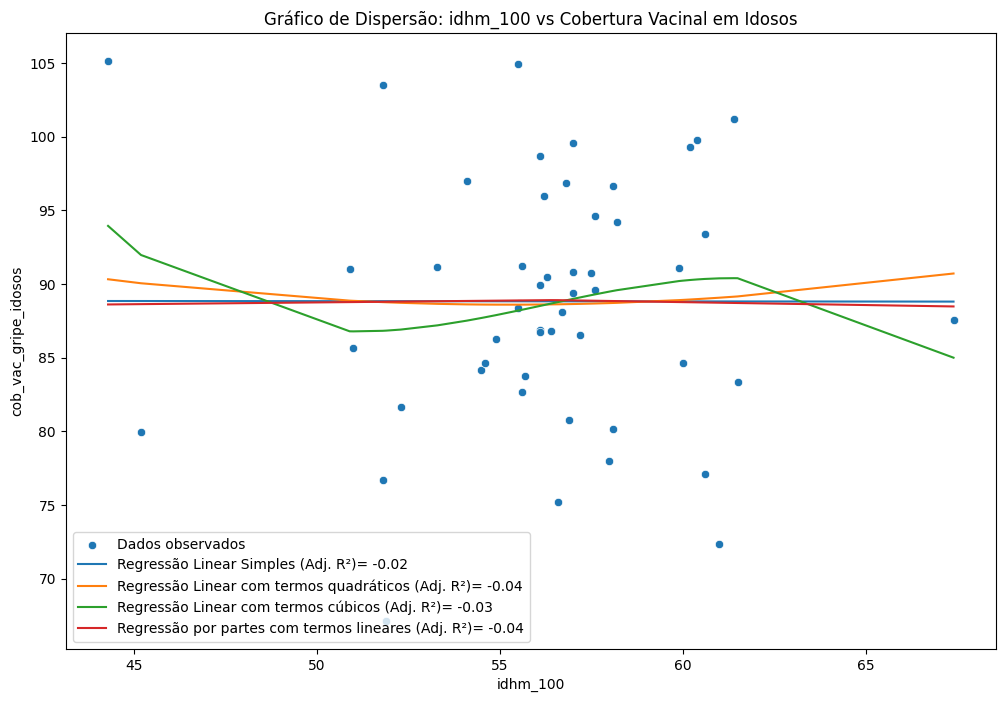

In [28]:
# Cria figura e eixos
fig, ax = plt.subplots(figsize=(12, 8))

# Plota o gráfico de dispersão no eixo ax
sns.scatterplot(df, x="idhm_100", y="cob_vac_gripe_idosos", ax=ax, label="Dados observados")

# Plota linhas de cada modelo de regressão
sns.lineplot(x=df["idhm_100"], y=reg_simples["predictions"], label = f"Regressão Linear Simples (Adj. R²)= {reg_simples['adj-r2']:.2f}",ax=ax)
sns.lineplot(x=df["idhm_100"], y=reg_quadratica["predictions"], label = f"Regressão Linear com termos quadráticos (Adj. R²)= {reg_quadratica['adj-r2']:.2f}",ax=ax)
sns.lineplot(x=df["idhm_100"], y=reg_cubica["predictions"], label=f"Regressão Linear com termos cúbicos (Adj. R²)= {reg_cubica['adj-r2']:.2f}", ax=ax)
sns.lineplot(x=df["idhm_100"], y=reg_piecewise["predictions"], label = f"Regressão por partes com termos lineares (Adj. R²)= {reg_piecewise['adj-r2']:.2f}", ax=ax)

# Escreve no eixo ax título do gráfico
ax.set_title("Gráfico de Dispersão: idhm_100 vs Cobertura Vacinal em Idosos")

# Escreva no eixo ax as legendas definidas nos labels
ax.legend()

plt.show()

Nota-se que todos os modelos se ajustam extremamente mal ao conjunto de dados, portanto não temos evidências de que há uma relacão relevante entre o idhm_100 e a cobertura vacinal e idosos, pelo menos no estado do MA, para o qual foi feita a análise. Se avaliamos o modelo com o melhor (ou menos pior) ajuste, esse seria o modelo de Regressão linear simples, pois tem o maior (menos negativo) valor para o R² ajustado. Além disso, como todos os modelos tem desempenhos (ruins) relativamnete próximos, por parcimônia, ele também seria o modelo a ser considerado.

De qualquer maneira, todos os modelos se ajustam muito mal ao conjunto de dados, de forma que não seria adequado usá-los "em producão".

## Exercício 2
A funcão que encapsula o diagnóstico de resíduos pode ser consultada na secão de funcões auxiliares, diagnóstico de resíduos do notebook. Essa funcão foi desenvolvida de acordo com os métodos sugeridos no material da disciplina.

### Modelo de regressão linear simples

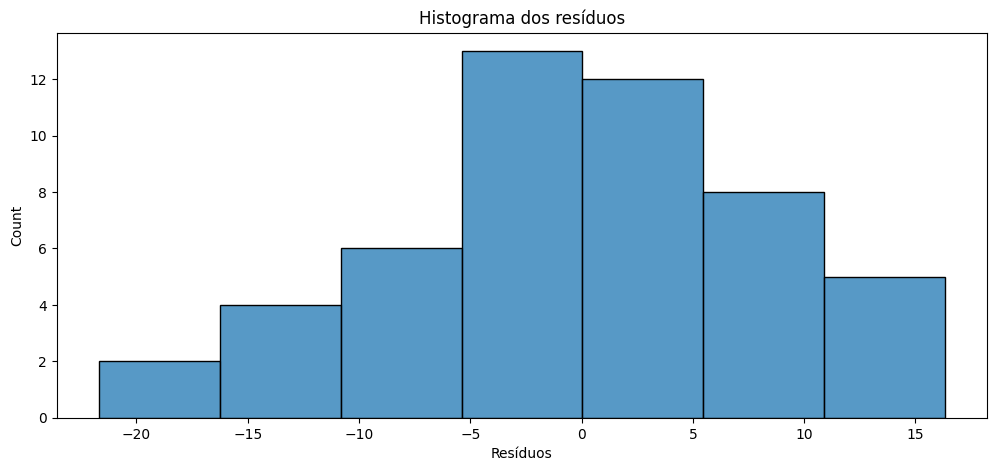

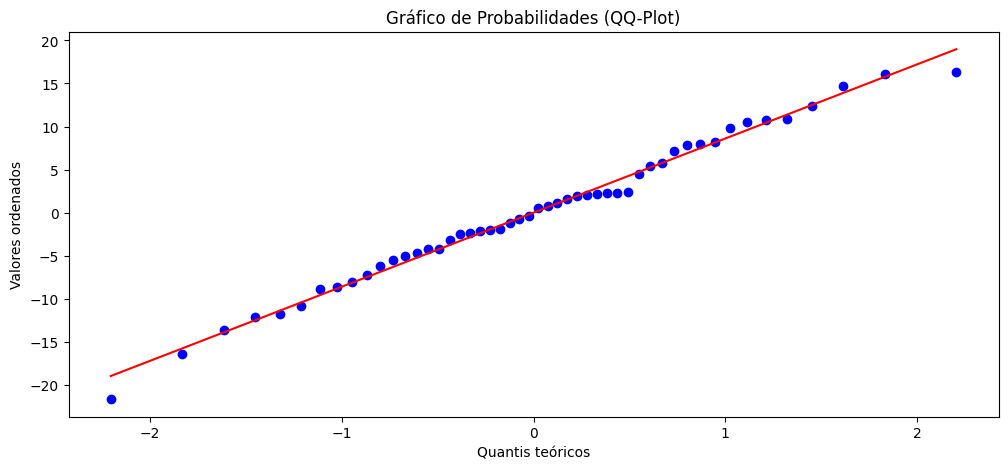

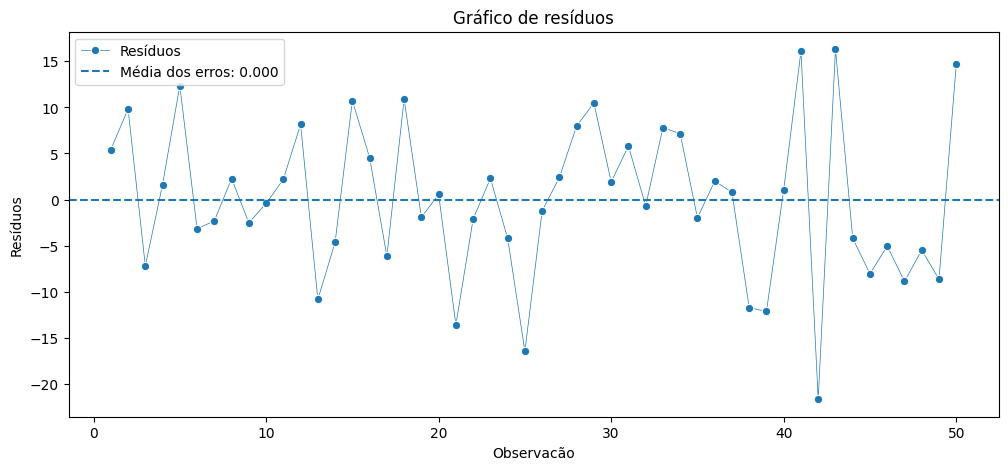

### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###
H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS
H1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS
Estatística de shapiro: 0.9891446828842163, p-valor do teste de Shapiro: 0.9241892695426941
### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###
H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) 
H1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)
Estatística do Lagrange Multiplier: 2.361507046469713, p-valor do teste de Breusch Pagan: 0.12436199586677006
### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###
VALOR DA ESTATÍSTICA DE DURBIN WATSON: 2.204888430832425
(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores par

In [29]:
reg_simples_diagnostico = diagnostico_de_residuos(
    e=reg_simples["residuals"],
    X=reg_simples["X"]
    )

### Modelo de regressão linear com termo quadrático

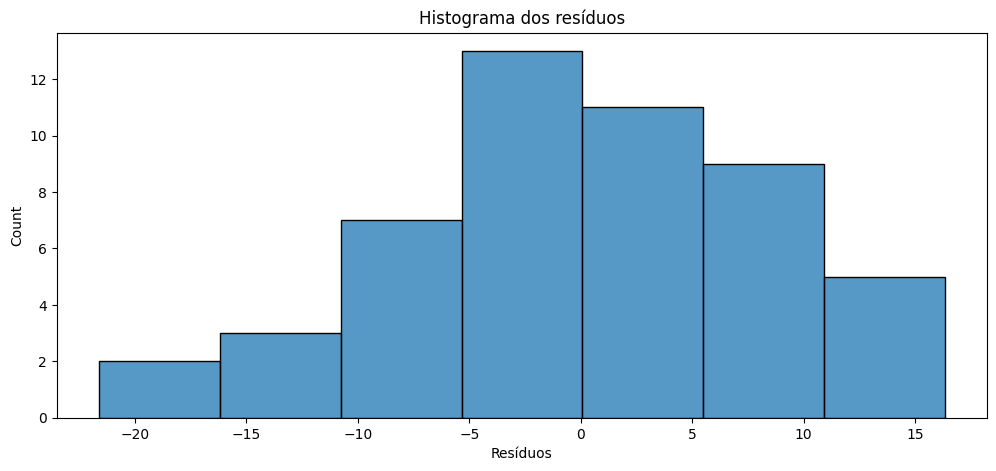

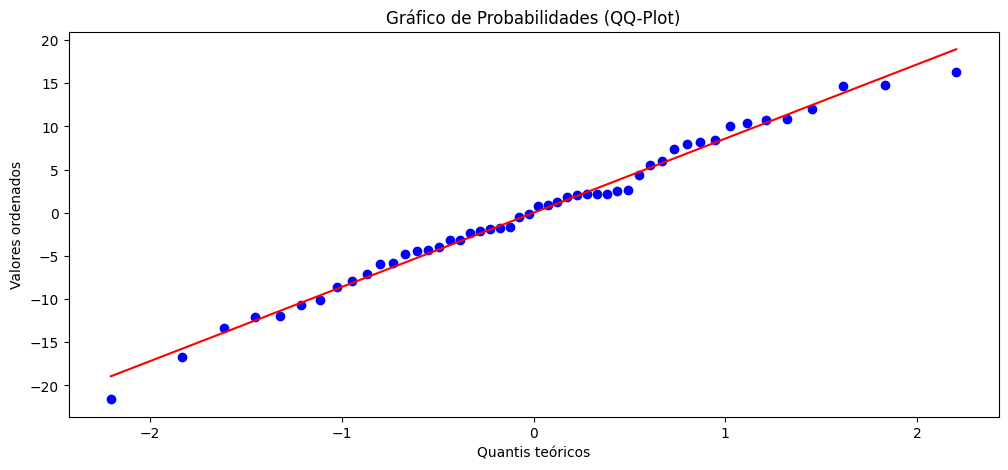

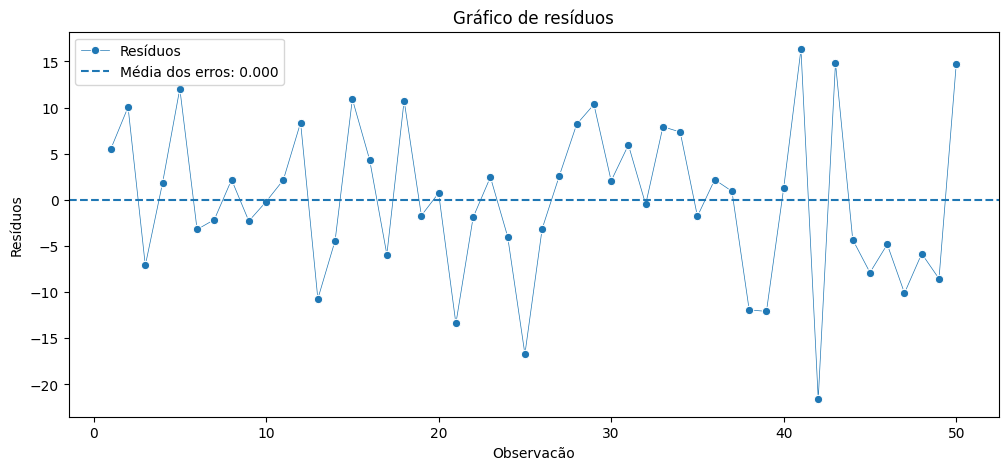

### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###
H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS
H1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS
Estatística de shapiro: 0.98833167552948, p-valor do teste de Shapiro: 0.8996933698654175
### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###
H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) 
H1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)
Estatística do Lagrange Multiplier: 3.4639206131477582, p-valor do teste de Breusch Pagan: 0.17693721858752443
### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###
VALOR DA ESTATÍSTICA DE DURBIN WATSON: 2.1535481435546946
(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores par

In [30]:
reg_quadratica_diagnostico = diagnostico_de_residuos(
    e = reg_quadratica["residuals"],
    X = reg_quadratica["X"]
    )

### Modelo de regressão linear com termo cúbico

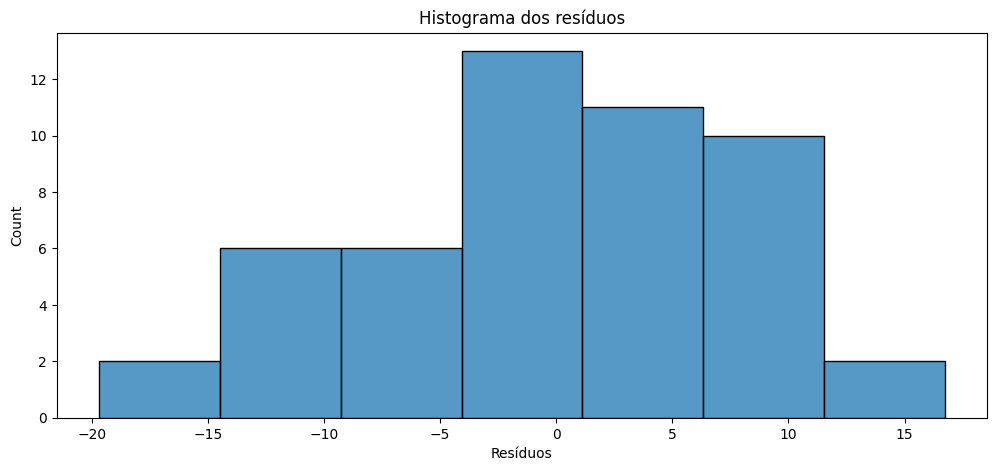

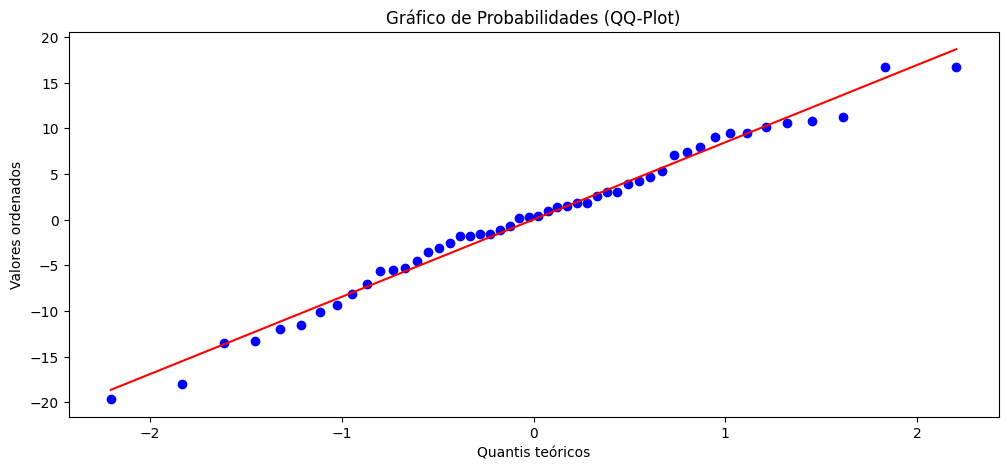

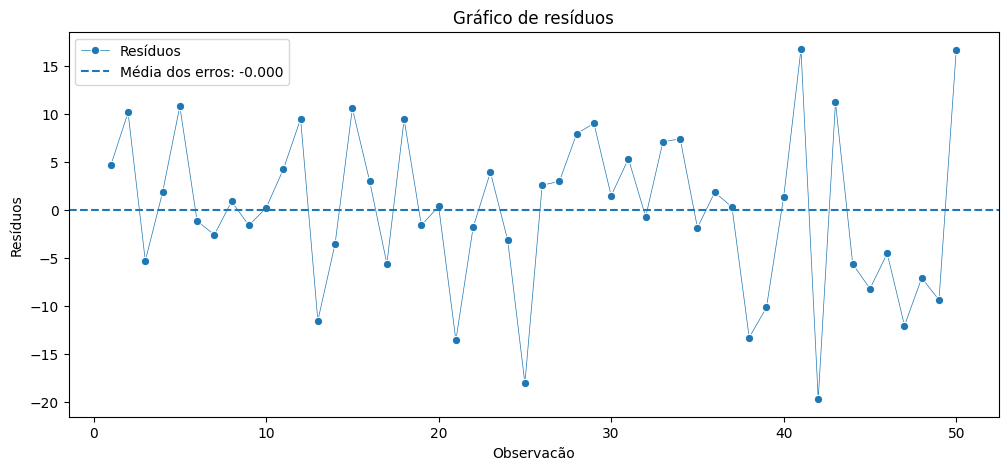

### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###
H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS
H1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS
Estatística de shapiro: 0.9853996634483337, p-valor do teste de Shapiro: 0.7886480093002319
### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###
H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) 
H1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)
Estatística do Lagrange Multiplier: 2.0961645771310264, p-valor do teste de Breusch Pagan: 0.5526890851468078
### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###
VALOR DA ESTATÍSTICA DE DURBIN WATSON: 2.093799931183361
(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores par

In [31]:
reg_cubica_diagnostico = diagnostico_de_residuos(
    e = reg_cubica["residuals"],
    X = reg_cubica["X"]
    )

### Modelo linear por partes (piecewise)

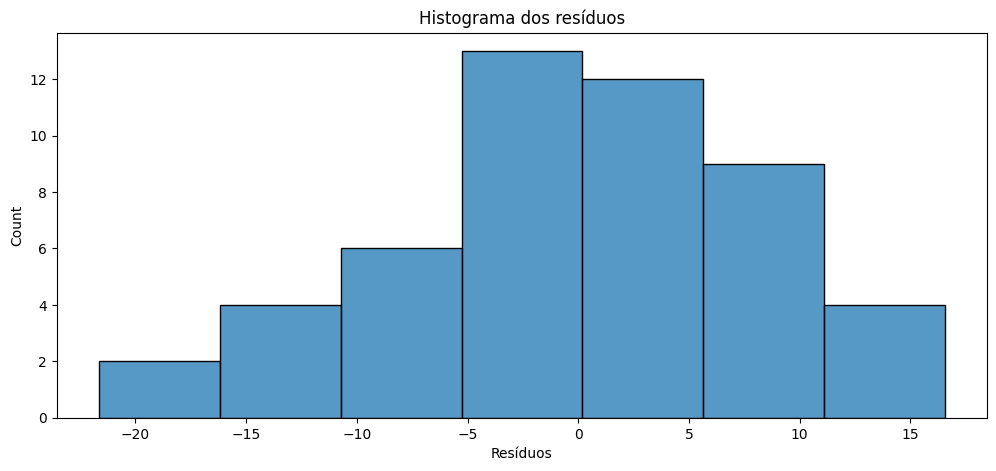

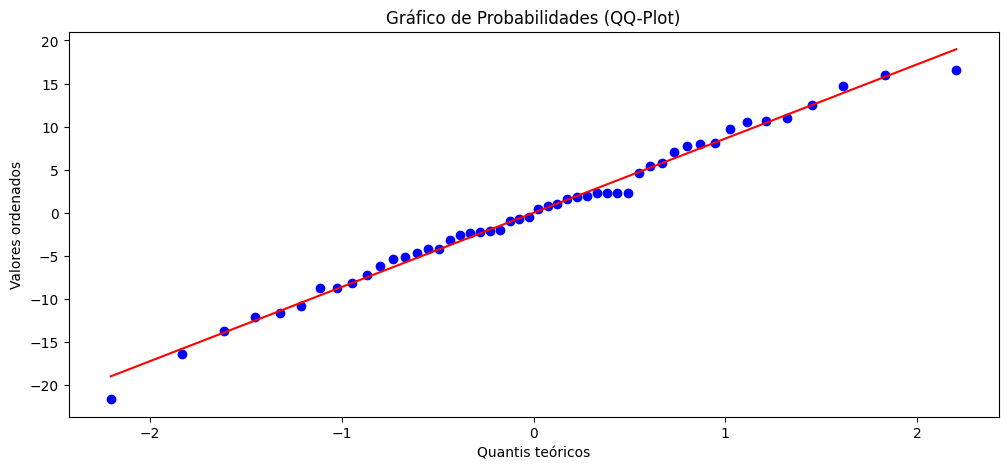

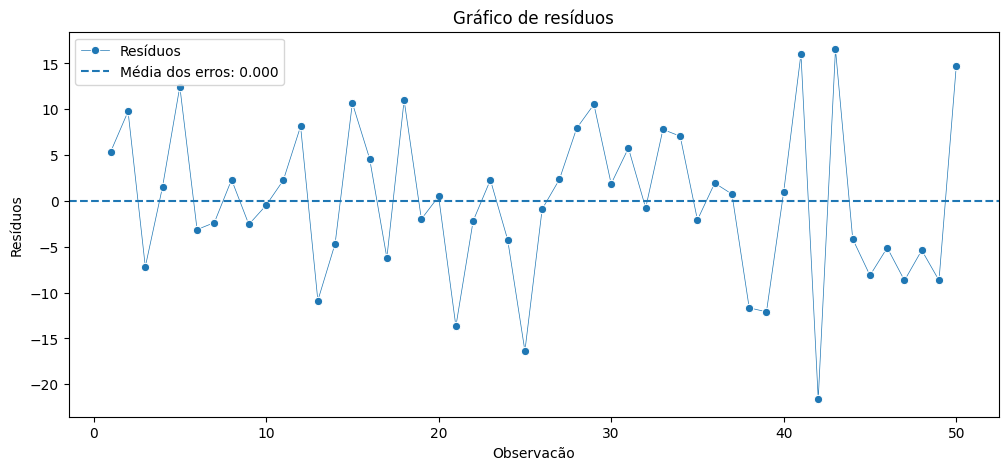

### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###
H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS
H1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS
Estatística de shapiro: 0.989794135093689, p-valor do teste de Shapiro: 0.941254198551178
### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###
H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) 
H1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)
Estatística do Lagrange Multiplier: 6.072536823711533, p-valor do teste de Breusch Pagan: 0.04801372305980457
### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###
VALOR DA ESTATÍSTICA DE DURBIN WATSON: 2.2133358820463362
(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores para

In [32]:
reg_piecewise_diagnostico = diagnostico_de_residuos(
    e = reg_piecewise["residuals"],
    X = reg_piecewise["X"]
    )

### Conclusões do exercício 2:

Nota-se um comportamento similar em todos os modelos. Vamos avaliá-los com respeito a cada premissa dos modelos de regressão linear:
#### Premissa da média dos resíduos = 0:
- Todos os modelos apresentam média 0 para os resíduos.

#### Premissa de normalidade dos erros (com média 0)
- Além da média 0, visualmente (histograma e QQ plot) parece razoável a suposicão de que os erros seguem uma distribuicão normal. Os dados tem boa aderência a reta do QQ plot, além de terem uma forma similar ao característico sino da funcão de densidade de probabilidade da Normal.
- Ademais, nenhum dos modelos rejeitou a hipótese nula de que os dados seguem uma distribuicão normal(assumindo um p-valor de 0.05)

### Premissa da homocedasticidade
- Não é possível observar um padrão claro na distribuicão dos erros, portanto não é possível identificar heterocedasticidade visualmente em nenhum dos modelos.
- Os resultados dos testes de Breusch Pagan corroboram com isso, de forma que apenas o modelo linear por partes violou a H0 de que a variância dos resíduos é constante (a um p-valor assumido de 0.05). Nesse sentido, apenas esse modelo tem uma desvantagem nesse sentido.

### Premissa da Não-autocorrelacão
- Apesar da possibilidade de testá-la diretamente pelo teste de durbin watson, o bom ajuste do modelo normal já nos dá evidência de que os resíduos são independentes. 

(A premissa da ausência de multicolinearidade não foi testada por não ter relacão direta com os resíduos)

Por fim: As premissas referentes aos resíduos podem ser consideradas atendidas de forma geral, com excecão da homocedasticidade no caso do modelo linear por partes. Esse modelo poderia ser preterido por isso. Fora isso, como os resultados são similares, por parcimônia, faz sentido escolher o modelo mais simples que, nesse caso, é o modelo de regressão linear simples. ALém disso, ele foi o que teve o melhor ajuste com relacão ao critério do R² ajustado no exercício anterior.

Portanto, o modelo escolhido é o linear simples.

## Exercício 3:

Primeiro, criaremos uma funcão auxiliar para calcular a tabela anova a partir dos resultados do ajuste dos modelos lineares.

In [47]:
def tabela_anova(resultados: dict) -> pd.DataFrame:
    """
    Gera a tabela ANOVA a partir do dicionário retornado por `regressao_linear`.
    """
    # Recupera quantidades básicas
    y_hat = resultados["predictions"]
    resid = resultados["residuals"]
    X = resultados["X"]
    n = X.shape[0]
    p = X.shape[1] - 1             # sem intercepto

    # Reconstrói y se não estiver nos resultados
    y = y_hat + resid
    y_mean = y.mean()

    # Somatórios
    ssr = np.sum((y_hat - y_mean) ** 2)          # Regression
    sse = np.sum(resid ** 2)                     # Error
    sst = ssr + sse                              # Total

    # Graus de liberdade
    df_reg   = p
    df_resid = n - p - 1
    df_total = n - 1

    # Médias quadráticas
    msr = ssr / df_reg
    mse = sse / df_resid

    # Estatística F global e p-valor
    F      = msr / mse
    pvalue = f.sf(F, df_reg, df_resid)

    # Monta DataFrame
    anova = pd.DataFrame({
        "GL":   [df_reg, df_resid, df_total],
        "SQ":   [ssr,    sse,       sst],
        "MQ":   [msr,    mse,       np.nan],
        "F":    [F,      np.nan,    np.nan],
        "Pr(>F)": [pvalue, np.nan,  np.nan]
    },
        index=["Regressão", "Resíduo", "Total"]
    )

    return anova


In [48]:
def prepara_dummies(
    df: pd.DataFrame,
    y_col: Optional[str] = None,
    *,
    cat_cols: Optional[Sequence[str]] = None,
    drop_first: bool = True,
) -> Tuple[np.ndarray, Optional[np.ndarray], List[str]]:
    """
    Constrói a matriz de preditores X em formato NumPy pronta para a
    `regressao_linear`, convertendo variáveis categóricas em dummies.

    Parâmetros
    ----------
    df : DataFrame
        Dados completos (preditores +, opcionalmente, target).
    y_col : str ou None
        Nome da coluna alvo.  Se None, somente X é gerada.
    cat_cols : lista ou None
        Quais colunas tratar como categóricas.
        - Se None → detecta automaticamente colunas de dtype 'object' ou 'category'.
    drop_first : bool
        Remove a primeira dummy de cada categoria (evita multicolinearidade
        quando se usa intercepto).

    Retorno
    -------
    X : ndarray (n, p)
        Matriz de preditores sem coluna de 1s.
    y : ndarray ou None
        Vetor-alvo se `y_col` foi passado; caso contrário retorna None.
    feature_names : list[str]
        Nomes das colunas/dummies na mesma ordem de X.
    """
    # 1. Separa y, se solicitado
    if y_col is not None:
        y = df[y_col].to_numpy(dtype=float).ravel()
        X_df = df.drop(columns=[y_col]).copy()
    else:
        y = None
        X_df = df.copy()

    # 2. Identifica variáveis categóricas
    if cat_cols is None:
        cat_cols = [
            c for c in X_df.columns
            if pd.api.types.is_categorical_dtype(X_df[c])
            or pd.api.types.is_object_dtype(X_df[c])
        ]

    # 3. Converte para dummies
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=drop_first, dtype=float)

    # 4. Constrói matriz NumPy e devolve
    feature_names = X_df.columns.tolist()
    X = X_df.to_numpy(dtype=float)

    return X, y, feature_names


### a) Estimar o modelo de regressão múltipla

Antes de estimar o modelo de regressão múltipla, devemos eliminar algumas colunas.

In [49]:
# Droppando colunas solicitadas nas instrucões do exercicio. Além disso, se fez necessário remover o nome do município. Caso contrário, teríamos mais colunas (61) que observacões, o que impossibilita a estimacão por OLS.
df_anova = df.drop(["municipio_codigo", "uf", "regiao", "municipio_nome"], axis=1)

Também devemos calcular as colunas de variáveis dummies para coluna "tipo_urbano".

In [50]:
X_mul,y_mul, feature_names = prepara_dummies(df_anova, y_col="cob_vac_gripe_idosos")

/tmp/ipykernel_371055/3238380149.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_df[c])


Agora podemos estimar o modelo de regressão múltipla

In [51]:
reg_multipla = regressao_linear(X=X_mul, y=y_mul)
print_resultados(reg_multipla)

Intercepto: 108.17117718164018
Coeficientes beta (comecando em B_1): [ 5.59913555e+00 -5.03044882e-01 -3.46781536e-02 -1.29527627e-01
  3.19827169e-04  3.59843668e-02  2.73644718e-02  4.46026236e-02
  1.91575495e-01  5.13584631e-02 -3.71798886e+00 -1.10019654e+01]
R²: 0.19378324
R² Ajustado: -0.0677


### b) Calcular a tabela ANOVA para o modelo de regressão múltipla

E agora podemos calcular a tabela anova pro modelo de regressão múltipla.

In [52]:
tabela_anova(reg_multipla)

,GL,SQ,MQ,F,Pr(>F)
Regressão,12,674.265029,56.188752,0.741114,0.70314
Resíduo,37,2805.215621,75.816638,NaN,NaN
Total,49,3479.480650,NaN,NaN,NaN


Verificando a estatística F, vemos que com um P-valor de aproximadamente 0.7 não rejeitamos a hipótese nula de que todos os coeficientes do modelo de regressão são iguais 0, ou seja, nosso modelo não é estatisticamente significativo. Assim, podemos dizer que não temos evidências que apontem que alguma variável do nosso conjunto de dados está relacionada a cobertura vacinal em idosos.

### d) Análise de resíduos do modelo de regressão múltipla

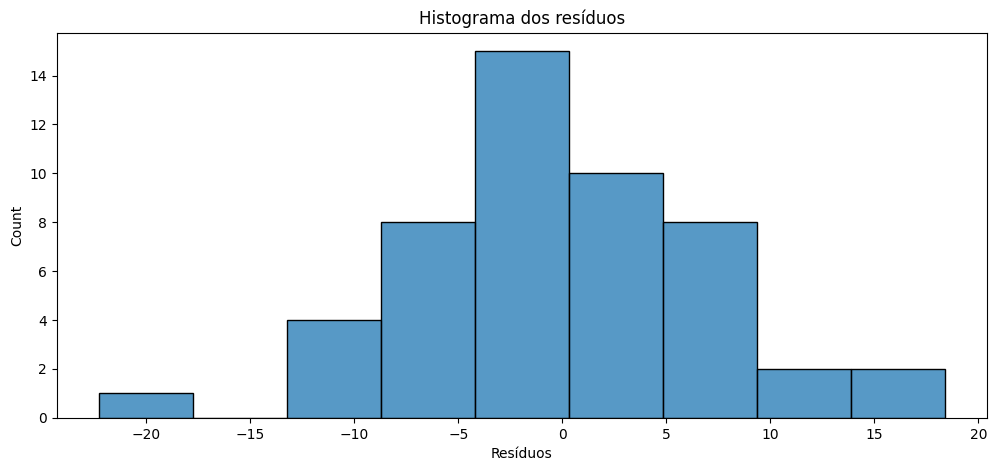

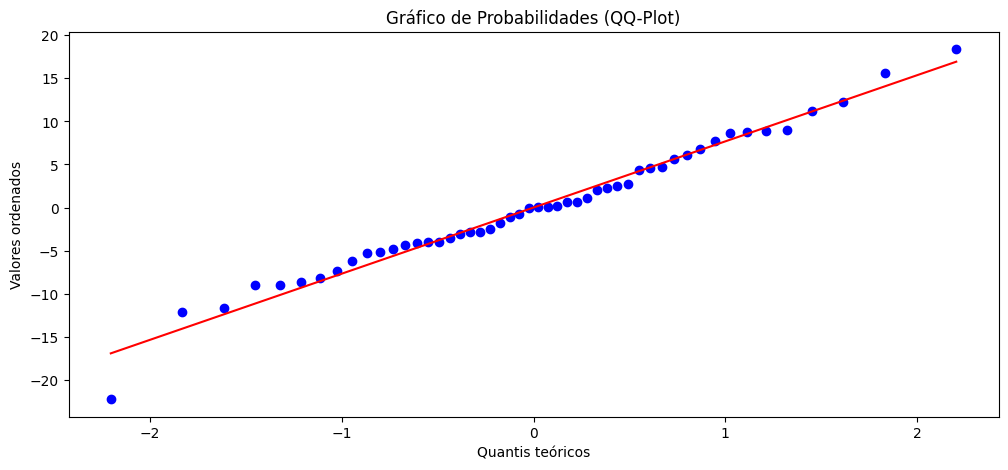

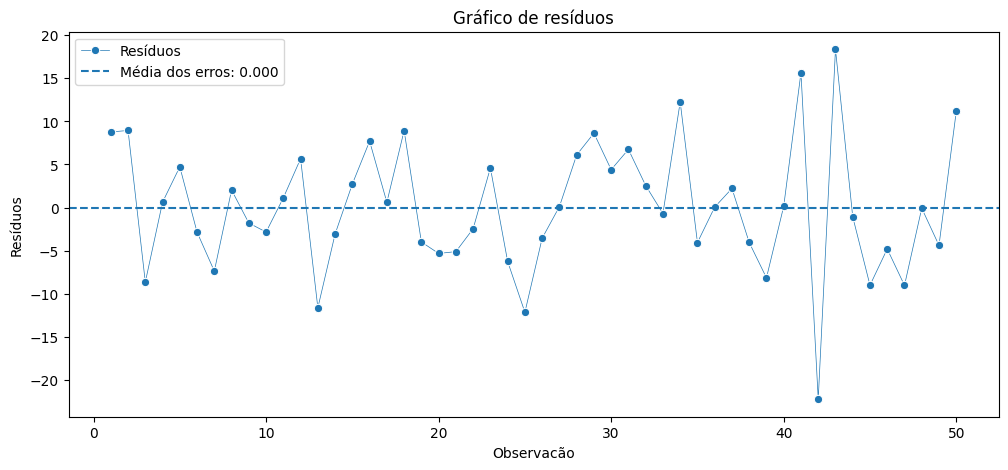

### ------------------------------------------------ TESTE DE SHAPIRO (NORMALIDADE) ------------------------------------------------ ###
H0: DADOS SÃO NORMALMENTE DISTRIBUIDOS
H1: DADOS NÃO SÃO NORMALMENTE DISTRIBUÍDOS
Estatística de shapiro: 0.9858865737915039, p-valor do teste de Shapiro: 0.8089597225189209
### ------------------------------------------------ TESTE DE BREUSCH PAGAN (HETEROCEDASTICIDADE) ------------------------------------------------ ###
H0: VARIÂNCIA DOS RESÍDUOS É CONSTANTE (HOMOCEDASTICIDADE) 
H1: VARIÂNCIA DOS RESÍDUOS NÃO É CONSTANTE (HETEROCEDASTICIDADE)
Estatística do Lagrange Multiplier: 18.69422595689641, p-valor do teste de Breusch Pagan: 0.09617973290067476
### ------------------------------------------------ TESTE DE DURBIN WATSON (AUTOCORRELACÃO) ------------------------------------------------ ###
VALOR DA ESTATÍSTICA DE DURBIN WATSON: 2.308165299407309
(Necessário verificar manualmente na tabela da DW o limites de aceitacão inferiores e superiores par

In [53]:
reg_multipla_diagnostico = diagnostico_de_residuos(reg_multipla["residuals"], X=reg_multipla["X"])